# The T-statistic in Action

In [1]:
import os
os.chdir('../scripts')
from analysis_tools_cython import *

In [2]:
meta = pd.read_csv('../metadata-combined.txt',sep= " " ,header=None,names=['filepath','TIC_ID','Tmag','Sector','Camera','Chip','RA','DEC','test'])

In [8]:
lc, lc_info = import_lightcurve(f"/storage/astro2/phrdhx/eleanor-lite-project-v2/s0017/{meta[(meta.TIC_ID == 430459104) & (meta.Sector == 17)].filepath.values[0]}")

In [10]:
lc = lc['TIME','PCA_FLUX','QUALITY','FLUX_ERR','X_CENTROID','Y_CENTROID','FLUX_BKG','CORR_FLUX']

In [45]:
_, _ = processing(lc,lc_info=lc_info,method='median')

In [13]:
original_table = lc.copy()
flat_flux, trend_flux = smoothing(lc, method='median')
table = Table([lc[lc.colnames[0]], flat_flux - np.ones(len(flat_flux)), lc[lc.colnames[2]], lc[lc.colnames[3]]/np.nanmedian(lc[lc.colnames[1]])],names=('time','flux','quality','flux_error'))
cleaning_ori_table = Table(original_table[original_table.colnames[:4]])
_ , nonnormalised_flux, _, _, _ = clean_data(cleaning_ori_table)
t, flux, quality, real, flux_error = clean_data(table)

## the interpolated flux is the one that is modeled, but for T-statistic, interpolated points are set to 0 to "flatten" the data gap and remove that as an FP.
flux_calc_shape = flux.copy()
flux *= real


## preparing processing
timestep = calculate_timestep(lc)
factor = ((1/48)/timestep)
N = len(t)
ones = np.ones(N)

## M-statistic
M_stat = calc_mstatistic(flux)

## Perform T-statistic search method
m,n,T1,minT,minT_time,minT_duration,Tm_start,Tm_end,Tm_depth,Ts = run_test_statistic(flux, factor, timestep,t)


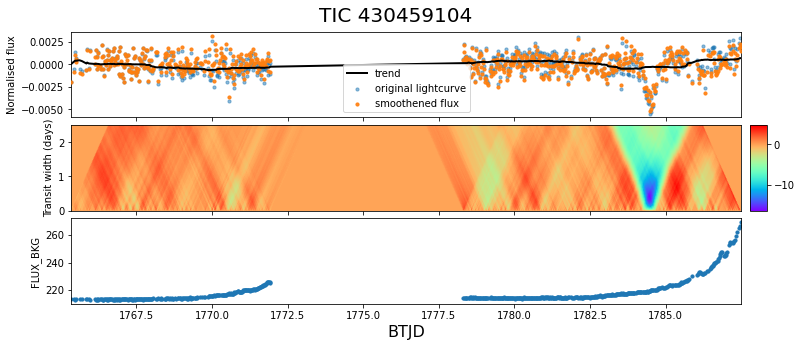

In [47]:
fig = plt.figure(figsize=(12,5)) ## change at top to plt.rcParams["figure.figsize"] = (10,6)

### table of results ###
gs = fig.add_gridspec(12,5 ,hspace=0.5,wspace=0.2)


### flux and the smoothing function ###
ax1 = plt.subplot(gs[0:4,:]) 
ax1.scatter(original_table[original_table.colnames[0]], normalise_flux(original_table[original_table.colnames[1]]), s=10,alpha=0.5,zorder=1,label='original lightcurve')
ax1.scatter(t[real==1], flux[real==1],label='smoothened flux',alpha=0.9,zorder=3,s=10)
try:
    ax1.plot(original_table[original_table.colnames[0]],normalise_flux(trend_flux),label='trend',color='black',linewidth=2,zorder=5)
except:
    pass

ax1.set_xlim(np.min(t),np.max(t))
ax1.set_ylabel("Normalised flux")
ax1.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

### transit cutout ###
# ax2 = plt.subplot(gs[2:10,:]) 
# try:
#     cutout_t = info[0]
#     cutout_x = info[1]
# except:
#     pass
# try:
#     gauss_fit = fits[0]
#     comet_fit = fits[1]
#     skew_fit = fits[2]

#     ax2.plot(cutout_t, cutout_x,label='data') # flux
#     ax2.plot(cutout_t,gauss_fit,label='gaussian model',color='orange',zorder=4) # gauss fit
#     ax2.plot(cutout_t,skew_fit,label='skewed gauss model',color='black',zorder=3) # skewed gaussian
#     #ax2.plot(cutout_t,comet_fit,label='comet model',color='lime',linestyle='-',zorder=1) # comet fit    
#     ax2.set_xlabel("Time - 2457000 (BTJD Days)")
#     ax2.legend(loc="lower left")
# except:
#     pass

###### T-statistic #######
ax3 = plt.subplot(gs[4:8, :])
im = ax3.imshow(
    T1,
    origin="bottom",
    extent=ax1.get_xlim() + (0, 2.5),
    aspect="auto",
    cmap="rainbow",
)
#ax3.set_xlabel("Time - 2457000 (BTJD Days)")
ax3.set_ylabel("Transit width (days)") 
plt.setp(ax3.get_xticklabels(), visible=False) 

cax = fig.add_axes([.91, ax3.get_position().min[1], 0.02, ax3.get_position().height])

fig.colorbar(im, cax=cax)

# Adjust the position of ax1 to make room for the colorbar
pos = ax3.get_position()
pos2 = ax3.get_position()
ax3.set_position([pos.x0, pos2.y0, pos.width, pos2.height])


#cbax = plt.subplot(gs[8:9, :2])
#cb = Colorbar(ax=cbax, mappable=im, orientation='horizontal', ticklocation='bottom')#et_x(-0.075)

## FLUX BACKGROUND PLOT ##
### the processed time array is not used for plotting purposes for background plots as they are unequal lengths to the original time array. 
### and we do not "clean" the background flux. This does not make a difference visually; just a coding explanation as to why we use this time value.
ax4 = plt.subplot(gs[8:, :],sharex=ax1)

bkg = original_table['FLUX_BKG']
#mad = np.nanmedian(np.abs(norm - np.nanmedian(norm)))
original_time = original_table[original_table.colnames[0]]
ax4.scatter(original_time,bkg,s=10)
#ax4.scatter(norm,norm[norm.colnames[4]],s=10)
#ax4.axhline(mad,label = "mad",color='black',linewidth=5)
#ax4.axhline(3*mad,label="3 x mad",color='red',linewidth=5)
ax4.set_ylabel('FLUX_BKG')
ax4.set_xlim(ax1.get_xlim())
#plt.setp(ax4.get_xticklabels(), visible=False)
# ax5 = plt.subplot(gs[11:14, :2],sharex=ax1)
# x_cen = original_table['X_CENTROID']
# ax5.scatter(original_time, x_cen, s=10)
# ax5.set_ylabel('X_CEN')
# ax5.set_xlim(ax1.get_xlim())
# plt.setp(ax5.get_xticklabels(), visible=False)

# ax6 = plt.subplot(gs[14:17, :2])
# y_cen = original_table['Y_CENTROID']
# ax6.scatter(original_time, y_cen, s=10)
# ax6.set_ylabel('Y_CEN')
# ax6.tick_params(axis='x', labelbottom=True) 
# ax6.set_xlim(ax1.get_xlim())
# ax6.set_xticklabels([])
plt.xlabel("BTJD", fontsize=16)
fig.suptitle('TIC 430459104',fontsize=20,y=0.95)
fig.tight_layout()
fig.savefig('../search-example.pdf',transparent=True,dpi=400,bbox_inches='tight')